In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from loguru import logger
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

load parquetfile from notebook 01.

In [16]:
import tomllib

configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
config

{'directories': {'raw': 'data/raw',
  'processed': 'data/processed',
  'input': '_chat.txt',
  'current': 'whatsapp-20251013-212815.parq',
  'preprocess_csv': 'whatsapp-20251018-161422-preprocess.csv',
  'preprocess_parq': 'whatsapp-20251018-161422-preprocess.parq',
  'cleaned_csv': 'whatsapp-20251018-161422-cleaned.csv',
  'cleaned_parq': 'whatsapp-20251018-161422-cleaned.parq',
  'feature_engineered_csv': 'whatsapp-20251018-161422-feature.csv',
  'feature_engineered_parq': 'whatsapp-20251018-161422-feature.parq',
  'categories_plot_png': 'categories_plot.png',
  'distribution_plot_png': 'distribution_plot.png',
  'correlation_plot_png': 'correlation_plot.png',
  'datetime_format': '%d-%m-%Y %H:%M',
  'drop_authors': []}}

In [5]:
print(config)

{'directories': {'raw': 'data/raw', 'processed': 'data/processed', 'input': '_chat.txt', 'current': 'whatsapp-20251013-212815.parq', 'preprocess_csv': 'whatsapp-20251018-161422-preprocess.csv', 'cleaned_csv': 'whatsapp-20251018-161422-cleaned.csv', 'feature_engineered_csv': 'whatsapp-20251018-161422-feature.csv', 'categories_plot_png': 'categories_plot.png', 'distribution_plot_png': 'distribution_plot.png', 'correlation_plot_png': 'correlation_plot.png', 'datetime_format': '%d-%m-%Y %H:%M', 'drop_authors': []}}


In [17]:
root = Path("..").resolve()
# Access 'processed' inside the 'directories' key
processed = root / Path(config["directories"]["processed"]) 
datafile = processed / config["directories"]["feature_engineered_parq"]

if not datafile.exists():
    logger.warning(
        f"{datafile} does not exist. First run src/preprocess.py, and check the timestamp!"
    )

Show datatypes

In [18]:
df = pd.read_parquet(datafile)
df.dtypes

timestamp                datetime64[ns, UTC]
message                               object
living_in_city                         int64
tech_background                        int64
author                                object
year                                   int32
month                                  int32
day                                    int32
hour                                   int32
minute                                 int32
day_of_week                           object
is_weekend                             int64
word_count                             int64
react_time_sec                       float64
react_time_sec_plus_1                float64
react_time_sec_log                   float64
react_time_min                       float64
react_time_min_plus_1                float64
react_time_min_log                   float64
react_time_hr                        float64
react_time_hr_plus_1                 float64
react_time_hr_log                    float64
is_image  

In [19]:
df.head()

,timestamp,message,living_in_city,tech_background,author,year,month,day,hour,minute,...,react_time_hr,react_time_hr_plus_1,react_time_hr_log,is_image,is_empty_message,is_removed_message,has_emoji,emoji_count,sentiment_polarity,sentiment_category
0,2022-09-16 07:31:00+00:00,Wachten op dit bericht,1,1,spattered-duck,2022,9,16,7,31,...,NaN,NaN,NaN,0,1,0,0,0,0.0,Neutral
1,2022-09-16 07:41:00+00:00,Wachten op dit bericht,0,1,riotous-dingo,2022,9,16,7,41,...,0.166667,1.166667,0.154151,0,1,0,0,0,0.0,Neutral
2,2022-09-16 08:21:00+00:00,Wachten op dit bericht,0,0,translucent-dog,2022,9,16,8,21,...,0.666667,1.666667,0.510826,0,1,0,0,0,0.0,Neutral
3,2022-09-16 08:23:00+00:00,Wachten op dit bericht,0,0,hypnotic-rabbit,2022,9,16,8,23,...,0.033333,1.033333,0.032790,0,1,0,0,0,0.0,Neutral
4,2022-09-16 09:08:00+00:00,Wachten op dit bericht,0,1,crystalline-uakari,2022,9,16,9,8,...,0.750000,1.750000,0.559616,0,1,0,0,0,0.0,Neutral


Count the number of messages over the years for technical vs non-technical background

In [22]:
# 1. Group by all three columns and count the messages (or rows)
# The result will be a Series where the index is the grouping columns
message_counts = df.groupby(['year', 'month', 'tech_background']).size().reset_index(name='message_count')

# Step 2: Pivot the table to make 'tech_background' values (0 and 1) into separate columns
pivot_table = message_counts.pivot_table(
    index=['year', 'month'],       # Keep year and month as the identifying rows
    columns='tech_background',     # Make unique values in this column into new columns
    values='message_count'         # Fill the new columns with these counts
).reset_index()

# Step 3: Rename the columns to reflect the desired output names (Average Count for that group)
final_averages = pivot_table.rename(
    columns={
        'non_tech_count': 'avg_messages_non_tech',
        'tech_count': 'avg_messages_tech'
    }
)

print(final_averages)

tech_background  year  month      0      1
0                2022      9   61.0   38.0
1                2022     10   68.0   53.0
2                2022     11  251.0  133.0
3                2022     12  343.0  254.0
4                2023      1  140.0  112.0
5                2023      2  247.0  237.0
6                2023      3   99.0   73.0
7                2023      4  171.0  109.0
8                2023      5  149.0  150.0
9                2023      6  180.0  211.0
10               2023      7  147.0  202.0
11               2023      8  177.0  158.0
12               2023      9  137.0  141.0
13               2023     10  155.0  162.0
14               2023     11  237.0  198.0
15               2023     12  197.0  166.0
16               2024      1  153.0  130.0
17               2024      2  150.0  122.0
18               2024      3  151.0   64.0
19               2024      4  267.0  256.0
20               2024      5  135.0  143.0
21               2024      6  171.0  100.0
22         

Count the number of messages

In [6]:
p1 = (
    df[["author", "message"]]
    .groupby("author")
    .count()
    .sort_values("message", ascending=False)
)

k = 15
topk = p1[:k]

In [7]:
topk_authors = list(topk.index)

In [8]:
df["is_topk"] = df["author"].apply(lambda x: x in topk_authors)
df.head()

,timestamp,message,living_in_city,tech_background,has_emoji,emoji_count,word_count,react_time_sec,react_time_min,react_time_hr,is_image,is_empty_message,is_removed_message,sentiment_polarity,sentiment_category,author,is_topk
0,2022-09-16 07:41:00+00:00,Wachten op dit bericht,0,0,False,0,4.0,NaN,NaN,NaN,0,1,0,0.0,Neutral,goofy-chimpanzee,True
1,2022-09-16 08:21:00+00:00,Wachten op dit bericht,0,0,False,0,4.0,2400.0,40.0,0.666667,0,1,0,0.0,Neutral,radiant-bee,True
2,2022-09-16 08:23:00+00:00,Wachten op dit bericht,0,0,False,0,4.0,120.0,2.0,0.033333,0,1,0,0.0,Neutral,whimsical-gorilla,True
3,2022-09-16 09:08:00+00:00,Wachten op dit bericht,0,0,False,0,4.0,2700.0,45.0,0.750000,0,1,0,0.0,Neutral,rubbery-butterfly,True
4,2022-09-16 09:23:00+00:00,Wachten op dit bericht,0,0,False,0,4.0,900.0,15.0,0.250000,0,1,0,0.0,Neutral,giggly-xenops,True


Text(0.5, 1.0, 'Sending the most messages...')

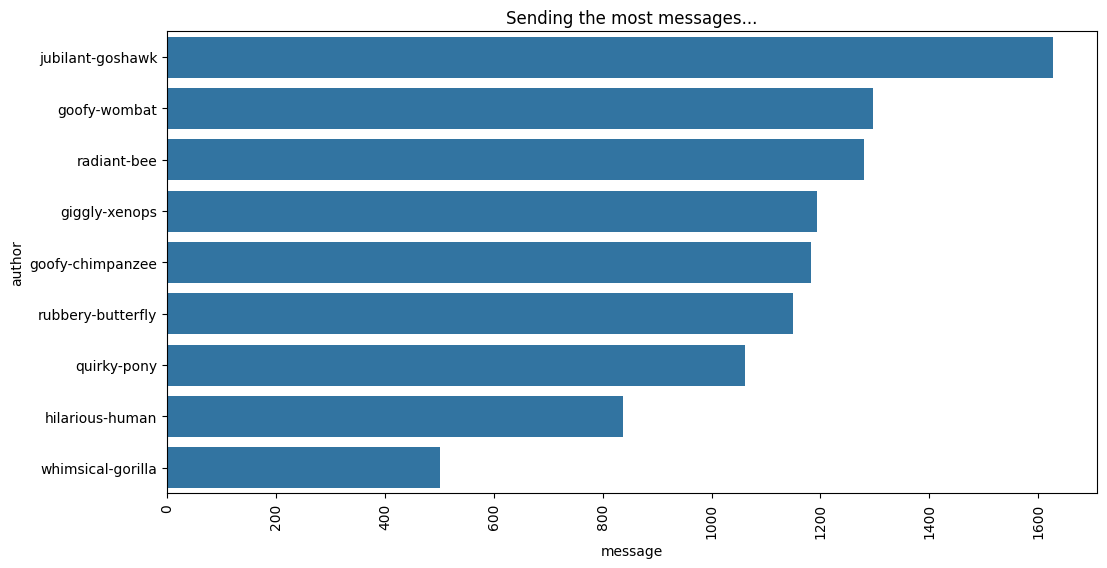

In [9]:
plt.figure(figsize=(12, 6))
sns.barplot(y=p1.index[:k], x="message", data=topk)
plt.xticks(rotation=90)
plt.title("Sending the most messages...")

Make overview of number of messages per day on average

In [22]:
df['day_of_week'] = df['timestamp'].dt.day_name()
df['date'] = df['timestamp'].dt.date
df['month'] = df['timestamp'].dt.month
df['year'] = df['timestamp'].dt.year
df.head()

,timestamp,message,living_in_city,tech_background,has_emoji,emoji_count,word_count,react_time_sec,react_time_min,react_time_hr,...,is_removed_message,sentiment_polarity,sentiment_category,author,is_topk,date,weekday,day_of_week,year,month
0,2022-09-16 07:41:00+00:00,Wachten op dit bericht,0,0,False,0,4.0,NaN,NaN,NaN,...,0,0.0,Neutral,goofy-chimpanzee,True,2022-09-16,Friday,Friday,2022,9
1,2022-09-16 08:21:00+00:00,Wachten op dit bericht,0,0,False,0,4.0,2400.0,40.0,0.666667,...,0,0.0,Neutral,radiant-bee,True,2022-09-16,Friday,Friday,2022,9
2,2022-09-16 08:23:00+00:00,Wachten op dit bericht,0,0,False,0,4.0,120.0,2.0,0.033333,...,0,0.0,Neutral,whimsical-gorilla,True,2022-09-16,Friday,Friday,2022,9
3,2022-09-16 09:08:00+00:00,Wachten op dit bericht,0,0,False,0,4.0,2700.0,45.0,0.750000,...,0,0.0,Neutral,rubbery-butterfly,True,2022-09-16,Friday,Friday,2022,9
4,2022-09-16 09:23:00+00:00,Wachten op dit bericht,0,0,False,0,4.0,900.0,15.0,0.250000,...,0,0.0,Neutral,giggly-xenops,True,2022-09-16,Friday,Friday,2022,9


In [ ]:

analysis = df.groupby('weekday').agg(
    total_messages=('message', 'count'),
    unique_days=('date', 'nunique')
).reset_index()

analysis['average_messages_per_day'] = analysis['total_messages'] / analysis['unique_days']

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
analysis['weekday'] = pd.Categorical(analysis['weekday'], categories=weekday_order, ordered=True)
result = analysis.sort_values('weekday')[['weekday', 'average_messages_per_day']]

print(result)

     weekday  average_messages_per_day
1     Monday                 10.870968
5    Tuesday                 15.084337
6  Wednesday                 11.956522
4   Thursday                 15.228261
0     Friday                 14.834862
2   Saturday                 18.032258
3     Sunday                 15.587629


Add Median

In [17]:
# 2. Group by date and weekday to get the count of messages for each *unique* day
daily_counts = df.groupby(['date', 'day_of_week'])['timestamp'].size().reset_index(name='daily_message_count')

# 3. Group the daily counts by weekday and calculate the average and median
analysis = daily_counts.groupby('day_of_week')['daily_message_count'].agg(
    average_messages=('mean'),
    median_messages=('median')
).reset_index()

# 4. Sort the results in calendar order (optional)
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
analysis['day_of_week'] = pd.Categorical(analysis['day_of_week'], categories=weekday_order, ordered=True)
result = analysis.sort_values('day_of_week')

print(result)

  day_of_week  average_messages  median_messages
1      Monday         10.881720              6.0
5     Tuesday         15.084337              7.0
6   Wednesday         11.989130              7.0
4    Thursday         15.228261              8.5
0      Friday         14.834862              9.0
2    Saturday         18.032258             12.0
3      Sunday         15.608247             11.0


Average and Median per Weekday per Year

    year day_of_week  average_messages  median_messages
1   2022      Monday         20.500000              8.0
5   2022     Tuesday         24.416667             15.0
6   2022   Wednesday          5.500000              5.0
4   2022    Thursday         19.300000              8.5
0   2022      Friday         20.181818              8.0
2   2022    Saturday         13.083333              9.5
3   2022      Sunday         12.888889              3.0
8   2023      Monday         12.470588              7.0
12  2023     Tuesday         11.172414              6.0
13  2023   Wednesday         11.787879              9.0
11  2023    Thursday         15.914286              8.0
7   2023      Friday         15.756757             13.0
9   2023    Saturday         19.170213             11.0
10  2023      Sunday         20.447368             14.5
15  2024      Monday         10.187500              7.0
19  2024     Tuesday         16.370370              7.0
20  2024   Wednesday         12.037037          

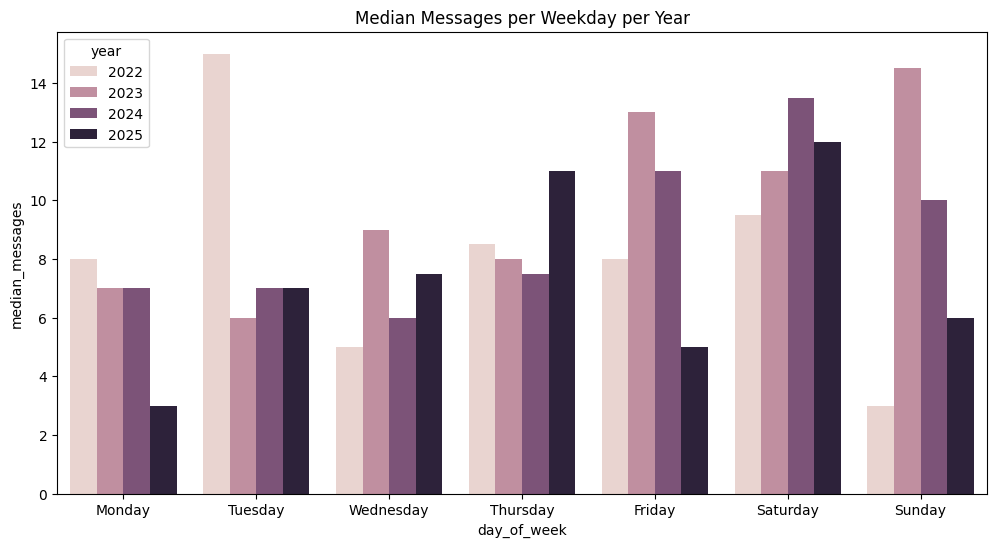

In [ ]:
# 2. Group by date and weekday to get the count of messages for each *unique* day
daily_counts = df.groupby(['date', 'day_of_week', 'year'])['timestamp'].size().reset_index(name='daily_message_count')

# 3. Group the daily counts by weekday and calculate the average and median
analysis = daily_counts.groupby(['year', 'day_of_week'])['daily_message_count'].agg(
    average_messages=('mean'),
    median_messages=('median')
).reset_index()

# 4. Sort the results in calendar order (optional)
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
analysis['day_of_week'] = pd.Categorical(analysis['day_of_week'], categories=weekday_order, ordered=True)
result = analysis.sort_values(['year', 'day_of_week'])

graph = plt.figure(figsize=(12, 6))
sns.barplot(x='day_of_week', y='median_messages', hue='year', data=result)
plt.title('Median Messages per Weekday per Year')

graph = plt.figure(figsize=(12, 6))
sns.barplot(x='day_of_week', y='average_messages', hue='year', data=result)
plt.title('Average Messages per Weekday per Year')

print(result)



Activity per Month and Weekday

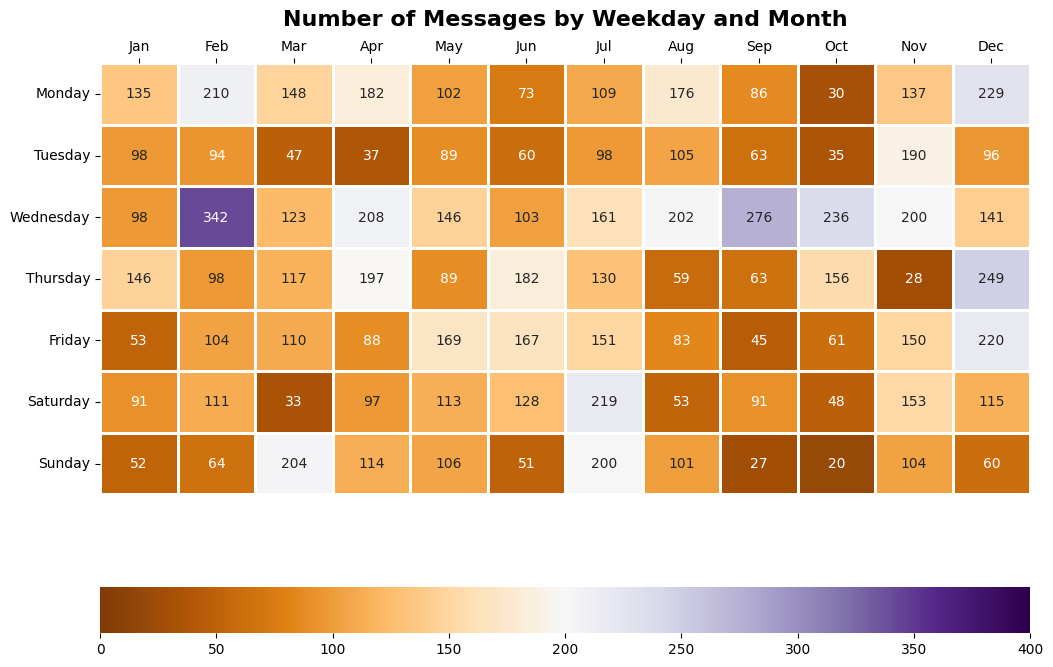

In [24]:
import calendar

DayMonth = df.groupby(['day_of_week','month']).size().reset_index(name='counts')

DayMonth_wide = DayMonth.pivot(index='day_of_week', columns='month', values='counts')
#Order columns and Index
month_order_abbr = list(calendar.month_abbr)
DayMonth_wide.columns = month_order_abbr[1:13]

day_order = list(calendar.day_name)
DayMonth_wide.index = day_order

plt.figure(figsize=(12,8))

ax = sns.heatmap(DayMonth_wide, annot=True, fmt='.0f', yticklabels='auto', cmap='PuOr', 
                 linewidths=1.8, cbar_kws={"orientation": "horizontal"},vmin = 0,vmax = 400)
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
ax.set_title('Number of Messages by Weekday and Month',fontsize = 16,weight = 'bold',pad=10)
plt.show()